In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
df_part4 =pd.read_csv('df_part4.csv')

In [17]:
df_part4.head(15)

,cell_id,cell_type,condition,win_ms,slope_V_per_s,mean_V,std_V,t_anchor_s,isi_ms,isi_cat
0,0,EXC,Pre-AP,2.5,1.104313,-0.035494,0.000825,1.355900,NaN,NaN
1,0,EXC,Baseline,2.5,0.269862,-0.043437,0.000207,10.010918,NaN,NaN
2,0,EXC,Pre-AP,3.5,0.644088,-0.035698,0.000770,1.355900,NaN,NaN
3,0,EXC,Baseline,3.5,0.034873,-0.045798,0.000055,0.887339,NaN,NaN
4,0,EXC,Pre-AP,4.5,0.355709,-0.035750,0.000686,1.355900,NaN,NaN
5,0,EXC,Baseline,4.5,0.425149,-0.037020,0.000590,10.486521,NaN,NaN
6,0,EXC,Pre-AP,2.5,1.499652,-0.040553,0.001170,2.994100,1638.2,Long
7,0,EXC,Baseline,2.5,0.015108,-0.046659,0.000039,15.862059,NaN,NaN
8,0,EXC,Pre-AP,3.5,1.013011,-0.040929,0.001154,2.994100,1638.2,Long
9,0,EXC,Baseline,3.5,-0.075667,-0.044638,0.000089,10.607930,NaN,NaN


In [18]:
import numpy as np
import pandas as pd

# =====================================================
# 0) Sécurité : s'assurer que isi_cat est de type objet
# =====================================================
df_part4["isi_cat"] = pd.Series(index=df_part4.index, dtype="object")

# =====================================================
# 1) Filtre : Pre-AP + win_ms = 2.5 + ISI valide
# =====================================================
mask_25 = (
    (df_part4["condition"] == "Pre-AP") &
    (df_part4["win_ms"] == 2.5) &
    df_part4["isi_ms"].notna() &
    np.isfinite(df_part4["isi_ms"].to_numpy())
)

df_pre_25 = df_part4.loc[mask_25, ["cell_type", "isi_ms"]].copy()

# =====================================================
# 2) Calcul des terciles par cell_type
# =====================================================
thr_25 = (
    df_pre_25
    .groupby("cell_type")["isi_ms"]
    .quantile([1/3, 2/3])
    .unstack()
    .rename(columns={1/3: "q33", 2/3: "q66"})
)

# Nettoyage : enlever les cas dégénérés
thr_25 = thr_25.dropna()
thr_25 = thr_25[thr_25["q33"] < thr_25["q66"]]

# =====================================================
# 3) Fonction d'assignation Short / Mid / Long
# =====================================================
def assign_isi_cat_25(cell_type, isi_ms):
    if (cell_type not in thr_25.index) or (not np.isfinite(isi_ms)):
        return np.nan

    q33 = thr_25.loc[cell_type, "q33"]
    q66 = thr_25.loc[cell_type, "q66"]

    if isi_ms < q33:
        return "Short"
    elif isi_ms <= q66:
        return "Mid"
    else:
        return "Long"

# =====================================================
# 4) Remplacement de isi_cat dans df_part4
# =====================================================
df_part4.loc[mask_25, "isi_cat"] = [
    assign_isi_cat_25(ct, isi)
    for ct, isi in zip(
        df_part4.loc[mask_25, "cell_type"],
        df_part4.loc[mask_25, "isi_ms"]
    )
]

# =====================================================
# 5) Vérifications rapides
# =====================================================
print("dtype isi_cat :", df_part4["isi_cat"].dtype)
print("\nRépartition isi_cat (Pre-AP, win=2.5 ms) :")
print(
    df_part4.loc[
        (df_part4["condition"] == "Pre-AP") &
        (df_part4["win_ms"] == 2.5),
        "isi_cat"
    ].value_counts(dropna=False)
)

# =====================================================
# 6) (Optionnel) sauvegarde des seuils
# =====================================================
thr_25.reset_index().to_csv("isi_terciles_by_cell_type_win25.csv", index=False)

dtype isi_cat : object

Répartition isi_cat (Pre-AP, win=2.5 ms) :
isi_cat
Mid      103755
Long     103719
Short    103697
NaN         759
Name: count, dtype: int64


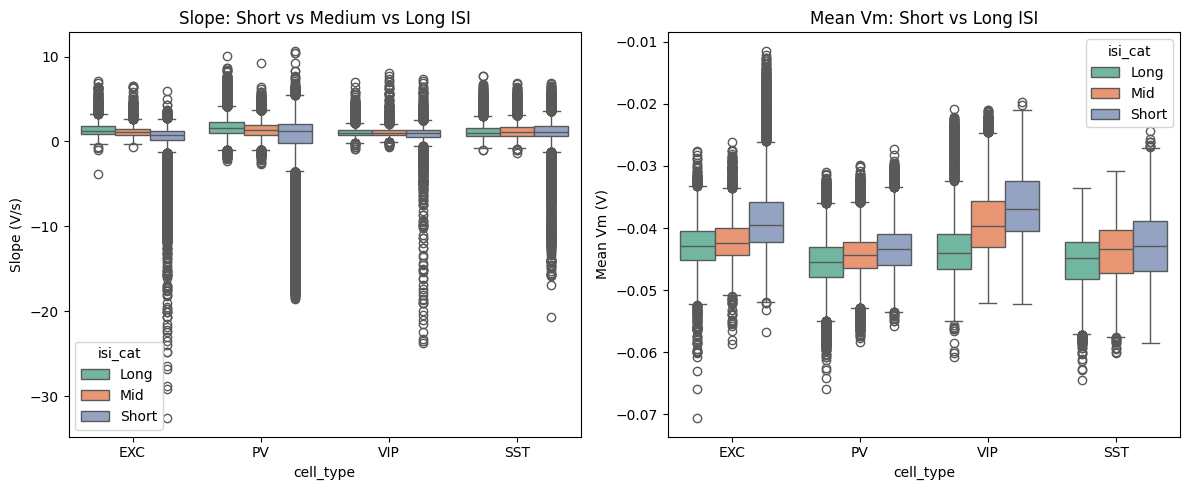

In [19]:
# =========================
# 3. VISUALIZATION: Impact of ISI (Pre-AP only)
# =========================

def plot_impact_ISI(win_ms, wanna_save = False):
    # We only look at "Pre-AP" condition to compare Short vs Long history
    df_isi = df_part4[
        (df_part4['condition'] == 'Pre-AP') & 
        (df_part4['win_ms'] == win_ms) & 
        (df_part4['isi_cat'].isin(['Short', 'Mid', 'Long'])) # Compare extremes
    ]
    
    plt.figure(figsize=(12, 5))
    
    # Plot Slope vs Cell Type, split by ISI Category
    plt.subplot(1, 2, 1)
    sns.boxplot(
        data=df_isi, 
        x='cell_type', 
        y='slope_V_per_s', 
        hue='isi_cat',
        palette='Set2'
    )
    plt.title("Slope: Short vs Medium vs Long ISI")
    plt.ylabel("Slope (V/s)")
    
    # Plot Threshold (Anchor Vm) vs Cell Type, split by ISI
    # Note: t_anchor_s is time, you might want the voltage at anchor
    # But mean_V is a good proxy for the subthreshold level
    plt.subplot(1, 2, 2)
    sns.boxplot(
        data=df_isi, 
        x='cell_type', 
        y='mean_V', 
        hue='isi_cat',
        palette='Set2'
    )
    plt.title("Mean Vm: Short vs Long ISI")
    plt.ylabel("Mean Vm (V)")
    
    plt.tight_layout()
    if wanna_save:
        plt.savefig('impact_ISI_on_features.png', dpi=300)
    plt.show()

plot_impact_ISI(2.5, False)

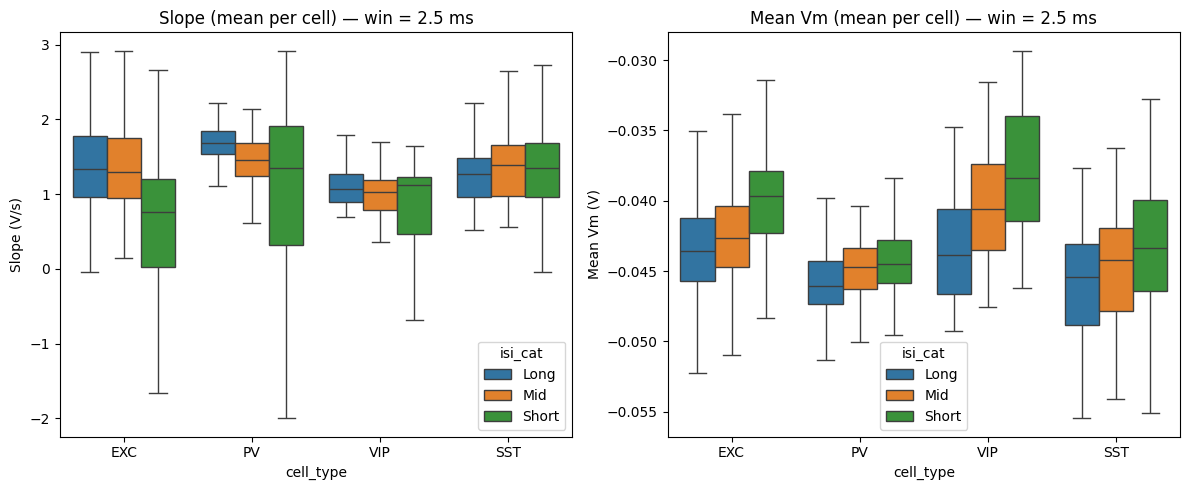


#cells par (cell_type x isi_cat):
isi_cat    Long  Mid  Short
cell_type                  
EXC         295  232    242
PV          161  161    161
SST         223  217    216
VIP          76   73     71


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_impact_ISI_cellmean(win_ms, wanna_save=False, min_spikes_per_cell=1):
    # 1) Filtrer Pre-AP, window, ISI categories
    df_isi = df_part4[
        (df_part4['condition'] == 'Pre-AP') &
        (df_part4['win_ms'] == win_ms) &
        (df_part4['isi_cat'].isin(['Short', 'Mid', 'Long']))
    ].copy()

    # (Optionnel) enlever les NaN dans les features
    df_isi = df_isi.dropna(subset=['slope_V_per_s', 'mean_V'])

    # 2) Compter le nombre de spikes par cellule dans chaque catégorie
    counts = (
        df_isi.groupby(['cell_id', 'cell_type', 'isi_cat'])
              .size()
              .reset_index(name='n_spikes')
    )

    # 3) Moyenne par cellule (dans chaque catégorie ISI)
    df_cell = (
        df_isi.groupby(['cell_id', 'cell_type', 'isi_cat'], as_index=False)
              .agg(
                  slope_V_per_s=('slope_V_per_s', 'mean'),
                  mean_V=('mean_V', 'mean'),
                  std_V=('std_V', 'mean'),
              )
    )

    # 4) Ajouter n_spikes et filtrer si tu veux un min de spikes
    df_cell = df_cell.merge(counts, on=['cell_id', 'cell_type', 'isi_cat'], how='left')
    df_cell = df_cell[df_cell['n_spikes'] >= min_spikes_per_cell]

    # 5) Plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.boxplot(
        data=df_cell,
        x='cell_type',
        y='slope_V_per_s',
        hue='isi_cat',
        showfliers=False
    )
    plt.title(f"Slope (mean per cell) — win = {win_ms} ms")
    plt.ylabel("Slope (V/s)")

    plt.subplot(1, 2, 2)
    sns.boxplot(
        data=df_cell,
        x='cell_type',
        y='mean_V',
        hue='isi_cat',
        showfliers=False
    )
    plt.title(f"Mean Vm (mean per cell) — win = {win_ms} ms")
    plt.ylabel("Mean Vm (V)")

    plt.tight_layout()
    if wanna_save:
        plt.savefig(f'impact_ISI_cellmean_win{win_ms}ms.png', dpi=300)
    plt.show()

    # 6) (Optionnel) afficher combien de cellules par groupe
    cell_counts = (
        df_cell.groupby(['cell_type', 'isi_cat'])['cell_id']
               .nunique()
               .unstack(fill_value=0)
    )
    print("\n#cells par (cell_type x isi_cat):")
    print(cell_counts)

# Exemple
plot_impact_ISI_cellmean(2.5, wanna_save=False, min_spikes_per_cell=1)


In [21]:
df_part4 =pd.read_csv('df_part4.csv')

In [22]:
import numpy as np
import pandas as pd

# =====================================================
# 0) Sécurité : s'assurer que isi_cat est de type objet
# =====================================================
df_part4["isi_cat"] = pd.Series(index=df_part4.index, dtype="object")

# =====================================================
# 1) Filtre : Pre-AP + win_ms = 2.5 + ISI valide
# =====================================================
mask_25 = (
    (df_part4["condition"] == "Pre-AP") &
    (df_part4["win_ms"] == 3.5) &
    df_part4["isi_ms"].notna() &
    np.isfinite(df_part4["isi_ms"].to_numpy())
)

df_pre_25 = df_part4.loc[mask_25, ["cell_type", "isi_ms"]].copy()

# =====================================================
# 2) Calcul des terciles par cell_type
# =====================================================
thr_25 = (
    df_pre_25
    .groupby("cell_type")["isi_ms"]
    .quantile([1/3, 2/3])
    .unstack()
    .rename(columns={1/3: "q33", 2/3: "q66"})
)

# Nettoyage : enlever les cas dégénérés
thr_25 = thr_25.dropna()
thr_25 = thr_25[thr_25["q33"] < thr_25["q66"]]

# =====================================================
# 3) Fonction d'assignation Short / Mid / Long
# =====================================================
def assign_isi_cat_25(cell_type, isi_ms):
    if (cell_type not in thr_25.index) or (not np.isfinite(isi_ms)):
        return np.nan

    q33 = thr_25.loc[cell_type, "q33"]
    q66 = thr_25.loc[cell_type, "q66"]

    if isi_ms < q33:
        return "Short"
    elif isi_ms <= q66:
        return "Mid"
    else:
        return "Long"

# =====================================================
# 4) Remplacement de isi_cat dans df_part4
# =====================================================
df_part4.loc[mask_25, "isi_cat"] = [
    assign_isi_cat_25(ct, isi)
    for ct, isi in zip(
        df_part4.loc[mask_25, "cell_type"],
        df_part4.loc[mask_25, "isi_ms"]
    )
]

# =====================================================
# 5) Vérifications rapides
# =====================================================
print("dtype isi_cat :", df_part4["isi_cat"].dtype)
print("\nRépartition isi_cat (Pre-AP, win=2.5 ms) :")
print(
    df_part4.loc[
        (df_part4["condition"] == "Pre-AP") &
        (df_part4["win_ms"] == 3.5),
        "isi_cat"
    ].value_counts(dropna=False)
)

# =====================================================
# 6) (Optionnel) sauvegarde des seuils
# =====================================================
thr_25.reset_index().to_csv("isi_terciles_by_cell_type_win25.csv", index=False)

dtype isi_cat : object

Répartition isi_cat (Pre-AP, win=2.5 ms) :
isi_cat
Mid      97313
Long     97192
Short    97075
NaN        754
Name: count, dtype: int64


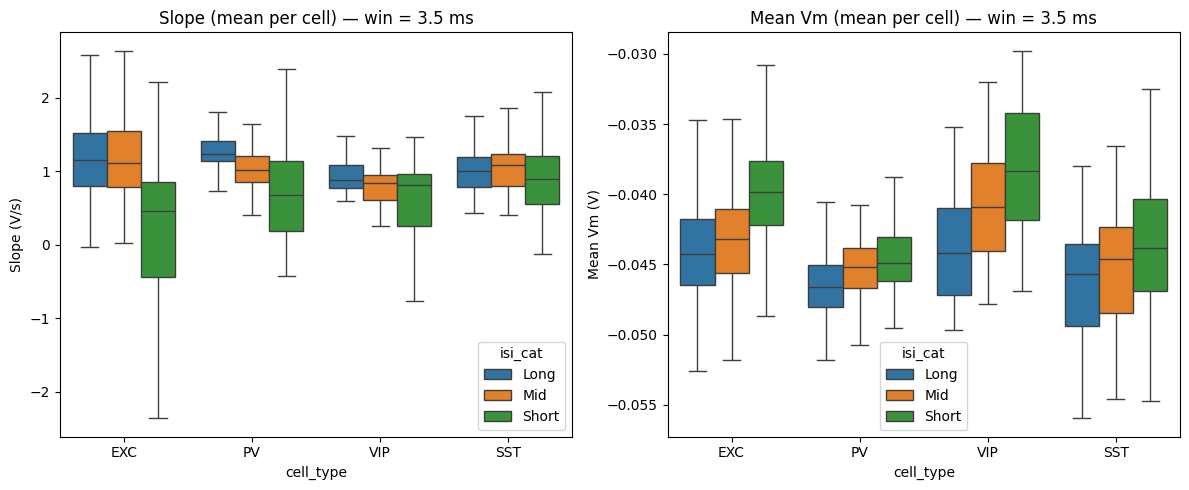


#cells par (cell_type x isi_cat):
isi_cat    Long  Mid  Short
cell_type                  
EXC         295  230    241
PV          161  161    161
SST         223  216    216
VIP          76   73     71


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_impact_ISI_cellmean(win_ms, wanna_save=False, min_spikes_per_cell=1):
    # 1) Filtrer Pre-AP, window, ISI categories
    df_isi = df_part4[
        (df_part4['condition'] == 'Pre-AP') &
        (df_part4['win_ms'] == win_ms) &
        (df_part4['isi_cat'].isin(['Short', 'Mid', 'Long']))
    ].copy()

    # (Optionnel) enlever les NaN dans les features
    df_isi = df_isi.dropna(subset=['slope_V_per_s', 'mean_V'])

    # 2) Compter le nombre de spikes par cellule dans chaque catégorie
    counts = (
        df_isi.groupby(['cell_id', 'cell_type', 'isi_cat'])
              .size()
              .reset_index(name='n_spikes')
    )

    # 3) Moyenne par cellule (dans chaque catégorie ISI)
    df_cell = (
        df_isi.groupby(['cell_id', 'cell_type', 'isi_cat'], as_index=False)
              .agg(
                  slope_V_per_s=('slope_V_per_s', 'mean'),
                  mean_V=('mean_V', 'mean'),
                  std_V=('std_V', 'mean'),
              )
    )

    # 4) Ajouter n_spikes et filtrer si tu veux un min de spikes
    df_cell = df_cell.merge(counts, on=['cell_id', 'cell_type', 'isi_cat'], how='left')
    df_cell = df_cell[df_cell['n_spikes'] >= min_spikes_per_cell]

    # 5) Plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.boxplot(
        data=df_cell,
        x='cell_type',
        y='slope_V_per_s',
        hue='isi_cat',
        showfliers=False
    )
    plt.title(f"Slope (mean per cell) — win = {win_ms} ms")
    plt.ylabel("Slope (V/s)")

    plt.subplot(1, 2, 2)
    sns.boxplot(
        data=df_cell,
        x='cell_type',
        y='mean_V',
        hue='isi_cat',
        showfliers=False
    )
    plt.title(f"Mean Vm (mean per cell) — win = {win_ms} ms")
    plt.ylabel("Mean Vm (V)")

    plt.tight_layout()
    if wanna_save:
        plt.savefig(f'impact_ISI_cellmean_win{win_ms}ms.png', dpi=300)
    plt.show()

    # 6) (Optionnel) afficher combien de cellules par groupe
    cell_counts = (
        df_cell.groupby(['cell_type', 'isi_cat'])['cell_id']
               .nunique()
               .unstack(fill_value=0)
    )
    print("\n#cells par (cell_type x isi_cat):")
    print(cell_counts)

# Exemple
plot_impact_ISI_cellmean(3.5, wanna_save=False, min_spikes_per_cell=1)


In [24]:
df_part4 =pd.read_csv('df_part4.csv')

In [25]:
import numpy as np
import pandas as pd

# =====================================================
# 0) Sécurité : s'assurer que isi_cat est de type objet
# =====================================================
df_part4["isi_cat"] = pd.Series(index=df_part4.index, dtype="object")

# =====================================================
# 1) Filtre : Pre-AP + win_ms = 2.5 + ISI valide
# =====================================================
mask_25 = (
    (df_part4["condition"] == "Pre-AP") &
    (df_part4["win_ms"] == 4.5) &
    df_part4["isi_ms"].notna() &
    np.isfinite(df_part4["isi_ms"].to_numpy())
)

df_pre_25 = df_part4.loc[mask_25, ["cell_type", "isi_ms"]].copy()

# =====================================================
# 2) Calcul des terciles par cell_type
# =====================================================
thr_25 = (
    df_pre_25
    .groupby("cell_type")["isi_ms"]
    .quantile([1/3, 2/3])
    .unstack()
    .rename(columns={1/3: "q33", 2/3: "q66"})
)

# Nettoyage : enlever les cas dégénérés
thr_25 = thr_25.dropna()
thr_25 = thr_25[thr_25["q33"] < thr_25["q66"]]

# =====================================================
# 3) Fonction d'assignation Short / Mid / Long
# =====================================================
def assign_isi_cat_25(cell_type, isi_ms):
    if (cell_type not in thr_25.index) or (not np.isfinite(isi_ms)):
        return np.nan

    q33 = thr_25.loc[cell_type, "q33"]
    q66 = thr_25.loc[cell_type, "q66"]

    if isi_ms < q33:
        return "Short"
    elif isi_ms <= q66:
        return "Mid"
    else:
        return "Long"

# =====================================================
# 4) Remplacement de isi_cat dans df_part4
# =====================================================
df_part4.loc[mask_25, "isi_cat"] = [
    assign_isi_cat_25(ct, isi)
    for ct, isi in zip(
        df_part4.loc[mask_25, "cell_type"],
        df_part4.loc[mask_25, "isi_ms"]
    )
]

# =====================================================
# 5) Vérifications rapides
# =====================================================
print("dtype isi_cat :", df_part4["isi_cat"].dtype)
print("\nRépartition isi_cat (Pre-AP, win=2.5 ms) :")
print(
    df_part4.loc[
        (df_part4["condition"] == "Pre-AP") &
        (df_part4["win_ms"] == 4.5),
        "isi_cat"
    ].value_counts(dropna=False)
)

# =====================================================
# 6) (Optionnel) sauvegarde des seuils
# =====================================================
thr_25.reset_index().to_csv("isi_terciles_by_cell_type_win25.csv", index=False)

dtype isi_cat : object

Répartition isi_cat (Pre-AP, win=2.5 ms) :
isi_cat
Mid      92311
Long     92031
Short    91859
NaN        744
Name: count, dtype: int64


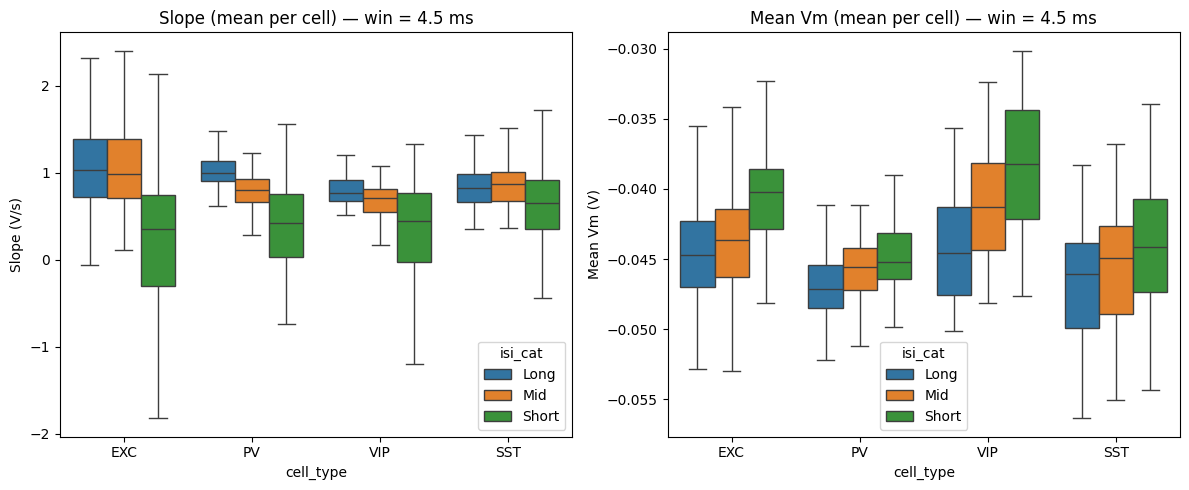


#cells par (cell_type x isi_cat):
isi_cat    Long  Mid  Short
cell_type                  
EXC         295  230    235
PV          161  161    161
SST         223  216    217
VIP          76   73     71


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_impact_ISI_cellmean(win_ms, wanna_save=False, min_spikes_per_cell=1):
    # 1) Filtrer Pre-AP, window, ISI categories
    df_isi = df_part4[
        (df_part4['condition'] == 'Pre-AP') &
        (df_part4['win_ms'] == win_ms) &
        (df_part4['isi_cat'].isin(['Short', 'Mid', 'Long']))
    ].copy()

    # (Optionnel) enlever les NaN dans les features
    df_isi = df_isi.dropna(subset=['slope_V_per_s', 'mean_V'])

    # 2) Compter le nombre de spikes par cellule dans chaque catégorie
    counts = (
        df_isi.groupby(['cell_id', 'cell_type', 'isi_cat'])
              .size()
              .reset_index(name='n_spikes')
    )

    # 3) Moyenne par cellule (dans chaque catégorie ISI)
    df_cell = (
        df_isi.groupby(['cell_id', 'cell_type', 'isi_cat'], as_index=False)
              .agg(
                  slope_V_per_s=('slope_V_per_s', 'mean'),
                  mean_V=('mean_V', 'mean'),
                  std_V=('std_V', 'mean'),
              )
    )

    # 4) Ajouter n_spikes et filtrer si tu veux un min de spikes
    df_cell = df_cell.merge(counts, on=['cell_id', 'cell_type', 'isi_cat'], how='left')
    df_cell = df_cell[df_cell['n_spikes'] >= min_spikes_per_cell]

    # 5) Plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.boxplot(
        data=df_cell,
        x='cell_type',
        y='slope_V_per_s',
        hue='isi_cat',
        showfliers=False
    )
    plt.title(f"Slope (mean per cell) — win = {win_ms} ms")
    plt.ylabel("Slope (V/s)")

    plt.subplot(1, 2, 2)
    sns.boxplot(
        data=df_cell,
        x='cell_type',
        y='mean_V',
        hue='isi_cat',
        showfliers=False
    )
    plt.title(f"Mean Vm (mean per cell) — win = {win_ms} ms")
    plt.ylabel("Mean Vm (V)")

    plt.tight_layout()
    if wanna_save:
        plt.savefig(f'impact_ISI_cellmean_win{win_ms}ms.png', dpi=300)
    plt.show()

    # 6) (Optionnel) afficher combien de cellules par groupe
    cell_counts = (
        df_cell.groupby(['cell_type', 'isi_cat'])['cell_id']
               .nunique()
               .unstack(fill_value=0)
    )
    print("\n#cells par (cell_type x isi_cat):")
    print(cell_counts)

# Exemple
plot_impact_ISI_cellmean(4.5, wanna_save=False, min_spikes_per_cell=1)

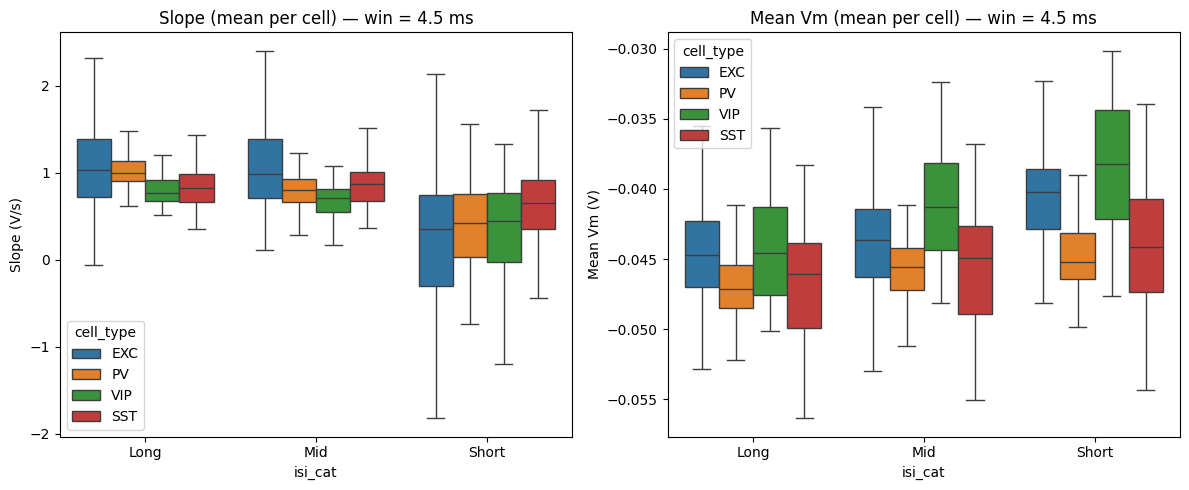


#cells par (cell_type x isi_cat):
isi_cat    Long  Mid  Short
cell_type                  
EXC         295  230    235
PV          161  161    161
SST         223  216    217
VIP          76   73     71


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_impact_ISI_cellmean(win_ms, wanna_save=False, min_spikes_per_cell=1):
    # 1) Filtrer Pre-AP, window, ISI categories
    df_isi = df_part4[
        (df_part4['condition'] == 'Pre-AP') &
        (df_part4['win_ms'] == win_ms) &
        (df_part4['isi_cat'].isin(['Short', 'Mid', 'Long']))
    ].copy()

    # (Optionnel) enlever les NaN dans les features
    df_isi = df_isi.dropna(subset=['slope_V_per_s', 'mean_V'])

    # 2) Compter le nombre de spikes par cellule dans chaque catégorie
    counts = (
        df_isi.groupby(['cell_id', 'cell_type', 'isi_cat'])
              .size()
              .reset_index(name='n_spikes')
    )

    # 3) Moyenne par cellule (dans chaque catégorie ISI)
    df_cell = (
        df_isi.groupby(['cell_id', 'cell_type', 'isi_cat'], as_index=False)
              .agg(
                  slope_V_per_s=('slope_V_per_s', 'mean'),
                  mean_V=('mean_V', 'mean'),
                  std_V=('std_V', 'mean'),
              )
    )

    # 4) Ajouter n_spikes et filtrer si tu veux un min de spikes
    df_cell = df_cell.merge(counts, on=['cell_id', 'cell_type', 'isi_cat'], how='left')
    df_cell = df_cell[df_cell['n_spikes'] >= min_spikes_per_cell]

    # 5) Plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.boxplot(
        data=df_cell,
        x='isi_cat',
        y='slope_V_per_s',
        hue='cell_type',
        showfliers=False
    )
    plt.title(f"Slope (mean per cell) — win = {win_ms} ms")
    plt.ylabel("Slope (V/s)")

    plt.subplot(1, 2, 2)
    sns.boxplot(
        data=df_cell,
        x='isi_cat',
        y='mean_V',
        hue='cell_type',
        showfliers=False
    )
    plt.title(f"Mean Vm (mean per cell) — win = {win_ms} ms")
    plt.ylabel("Mean Vm (V)")

    plt.tight_layout()
    if wanna_save:
        plt.savefig(f'impact_ISI_cellmean_win{win_ms}ms.png', dpi=300)
    plt.show()

    # 6) (Optionnel) afficher combien de cellules par groupe
    cell_counts = (
        df_cell.groupby(['cell_type', 'isi_cat'])['cell_id']
               .nunique()
               .unstack(fill_value=0)
    )
    print("\n#cells par (cell_type x isi_cat):")
    print(cell_counts)

# Exemple
plot_impact_ISI_cellmean(4.5, wanna_save=False, min_spikes_per_cell=1)